In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [40]:
# Load datasets
train_data = pd.read_csv("train.csv") # Labeled dataset, used for training the model
test_data = pd.read_csv("test.csv") # Unlabeled dataset, will be used later for making the prediction

In [ ]:
# Import libraries needed for working with text
import re
import unidecode
# from textblob import TextBlob
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# This is needed for nltk.download(...), otherwise downloading the NLTK files return errors
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK data files
nltk.download('stopwords')
# nltk.download('wordnet')
nltk.download('vader_lexicon')

import spacy 

# Load the spaCy model, which is later used for lemmatization
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

In [125]:
# Create custom dictionaries for slang words mapping

slang_dict = {
    # General abbreviations
    "u": "you",
    "r": "are",
    "ur": "your",
    "urs": "yours",
    "gr8": "great",
    "brb": "be right back",
    "btw": "by the way",
    "idk": "I don't know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "lmk": "let me know",
    "omg": "oh my god",
    "omfg": "oh my f***ing god",
    "ttyl": "talk to you later",
    "smh": "shaking my head",
    "fyi": "for your information",
    "jk": "just kidding",
    "nvm": "never mind",
    "bc": "because",
    "pls": "please",
    "plss": "please",
    "plsss": "please",
    "plz": "please",
    "thx": "thanks",
    "k": "okay",
    "tho": "though",
    "b4": "before",
    "asap": "as soon as possible",
    "bday": "birthday",
    "g2g": "got to go",
    "atm": "at the moment",
    "grats": "congratulations",
    "congrats": "congratulations",
    "omw": "on my way",
    "sry": "sorry",
    "thru": "through",
    "ttys": "talk to you soon",
    "w/": "with",
    "w/o": "without",
    "pkwy": "parkway",
    
    # Social media abbreviations
    "fb": "Facebook",
    "ig": "Instagram",
    "yt": "YouTube",
    "dm": "direct message",
    "rt": "retweet",
    "irl": "in real life",
    "fomo": "fear of missing out",
    "tbt": "throwback Thursday",
    "lmao": "laughing my a** off",
    "lmfao": "laughing my f***ing a** off",
    "yolo": "you only live once",
    "icymi": "in case you missed it",
    "hmu": "hit me up",
    "sm": "so much",
    
    # Text message and internet slang
    "y": "why",
    "kinda": "kind of",
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "finna": "fixing to",
    "lemme": "let me",
    "cya": "see you",
    "cu": "see you",
    "ppl": "people",
    "luv": "love",
    "bby": "baby",
    "bae": "before anyone else",
    "np": "no problem",
    "rn": "right now",
    "wyd": "what are you doing?",
    "wya": "where you at?",
    "ikr": "I know, right?",
    "fam": "family",
    "bruh": "brother",
    "sis": "sister",
    "thx": "thanks",
    "gg": "good game",
    "ez": "easy",
    "btwn": "between",
    "ftw": "for the win",
    "lit": "amazing",
    "sus": "suspicious",
    "l8r": "later",
    "2nite": "tonight",
    "tmi": "too much information",
    "jk": "just kidding",
    "oml": "oh my lord",
    "idc": "I don't care",
    "ily": "I love you",
    "ily2": "I love you too",
    
    # Numbers and shorthand phrases
    "b4n": "bye for now",
    "4u": "for you",
    "4eva": "forever",
    "2moro": "tomorrow",
    "2day": "today",
    "123": "I agree",
    "4real": "for real",
    
    # Curse words
    "wtf": "what the fuck",
    "wth": "what the hell",
    
    # Other social slang
    "rofl": "rolling on the floor laughing",
    "lol": "laughing out loud",
    "bff": "best friends forever",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "imho": "in my opinion",
    "bih": "bitch",
    "stan": "super fan",
    "savage": "bold",
    "noob": "newbie",
    "goat": "greatest of all time",
    "salty": "bitter",
    "yeet": "to throw or excited",
    "slay": "succeeding",
    
    # Hashtags (optional)
    "#tbt": "throwback Thursday",
    "#fomo": "fear of missing out",
    "#yolo": "you only live once"
}

emojis_dict = {
    # Common emoji-to-text replacements
    ":)": "happy",
    ":))": "happy",
    ":)))": "happy",
    ":)))": "happy",
    ":(": "sad",
    ":((": "sad",
    ":(((": "sad",
    ":D": "laughing",
    "xD": "laughing",
    ":P": "playful",
    "<3": "love"
}

In [129]:
# Define the methods used for data cleaning

def replace_percent_20(text):
    return text.replace('%20', ' ')

def replace_slang(tweet, slang_dict): # case insensitive
    return ' '.join([slang_dict.get(word.lower(), word) for word in tweet.split()])

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Lemmatize each token and join them back into a string
    lemmatized_words = [token.lemma_ for token in doc if token.text not in stop_words]
    return ' '.join(lemmatized_words)

def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)

    if sentiment_score['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def clean_text(text):
    if pd.isna(text):
        return ""

    # Remove mentions (e.g., @name)
    text = re.sub(r'@\w+', '', text)

    # Remove URL links
    text = re.sub(r'http\S+|www\S+|[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    # Remove # and split camel case (e.g., #BigFlood -> "Big Flood")
    text = re.sub(r'#', '', text)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

     # Remove numbers (since they don't add meaningful information)
    text = re.sub(r'\d+', '', text)

    # Remove multiple question and exclamation mark
    text = re.sub(r'(\?{2,}|\!{2,})', '', text)

    # Replace emojis
    text = replace_slang(text, emojis_dict)

    # Remove non-ASCII characters explicitly (just in case)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Explicitly remove underscores and hyphens
    text = text.replace('_', '').replace('-', '')

    # Replace slang words
    text = replace_slang(text, slang_dict)

    # Remove diacritic
    text = unidecode.unidecode(text)

    # Correct spelling using TextBlob # Not using it now, because it is computionally time consuming
    # text = str(TextBlob(text).correct())

    # Lowercase
    text = text.lower()

    cleaned_text = lemmatize_text(text)

    return cleaned_text

def clean_and_prepare_data(df):
    clean_df = df.copy()

    # Drop location column, because it doesn't bring any information about the disaster itself
    clean_df.drop(columns=['location'], inplace=True)

    # Fill missing values with empty values and clean it
    clean_df['keyword'].fillna('', inplace=True)
    clean_df['keyword'] = clean_df['keyword'].apply(clean_text)
    clean_df['keyword'] = clean_df['keyword'].apply(replace_percent_20) #TODDO ???

    clean_df['text'] = clean_df['text'].apply(clean_text)

    # Combine 'keyword' and 'text' columns
    clean_df['combined_text'] = clean_df.apply(lambda row: f"{row['keyword']} {row['text']}", axis=1)

    # Add sentiment column, calculation of the sentiment is based on already cleaned combined_text column
    clean_df['sentiment'] = clean_df['combined_text'].apply(get_sentiment)

    return clean_df

In [130]:
clean_train_data = clean_and_prepare_data(train_data)

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the text into numerical features using techniques like TF-IDF
# TF (Term Frequency) counts how often a word appears in a tweet.
# IDF (Inverse Document Frequency) reduces the impact of common words (like "the", "and"), giving more importance to rare, discriminative words like "flood", "earthquake", etc., which can indicate disasters.
# TfidfVectorizer is simple and doesn't require complex preprocessing compared to deep learning methods like word embeddings (e.g., Word2Vec).

vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(clean_train_data['combined_text'])

In [132]:
# Transform sentiment to numerical values
sentiment_mapping = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

clean_train_data['sentiment_encoded'] = clean_train_data['sentiment'].map(sentiment_mapping)

sentiment_encoded = np.array(clean_train_data['sentiment_encoded']).reshape(-1, 1) # reshape, so it can be used in hstack

In [112]:
from scipy.sparse import hstack

# Put together vectorized text with encoded sentiment using hstack to create feature matrix which can be later used as input to the model
X_combined = hstack([vectorized_text, sentiment_encoded])

In [134]:
X_combined.shape # here we can see that the feature matrix has 7613 rows and 12030 columns

(7613, 12030)

In [143]:
from sklearn.model_selection import train_test_split

# Define target variable
y = clean_train_data['target']

# Split the data, use stratify to get the splits with equally distributed targets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

In [136]:
X_train.shape

(6090, 12030)

In [137]:
X_test.shape

(1523, 12030)

In [148]:
# Let's try just some basic model such as Random Forest to see the evaluation metrics results

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf_random_forest = RandomForestClassifier()

clf_random_forest.fit(X_train, y_train)

y_pred_random_forest = clf_random_forest.predict(X_test)

print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       869
           1       0.85      0.66      0.74       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_matrix_heat_map(y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-disaster', 'Disaster'], yticklabels=['Non-disaster', 'Disaster'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

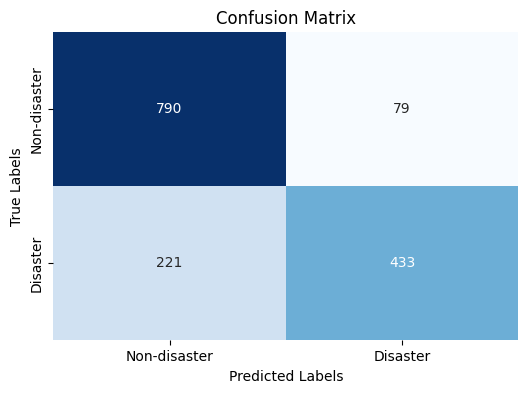

In [154]:
confusion_matrix_heat_map(y_pred_random_forest)

In [147]:
# Let's try Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_log_regression = LogisticRegression()

clf_log_regression.fit(X_train, y_train)

y_pred_log_regression = clf_log_regression.predict(X_test)

print(classification_report(y_test, y_pred_log_regression))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523



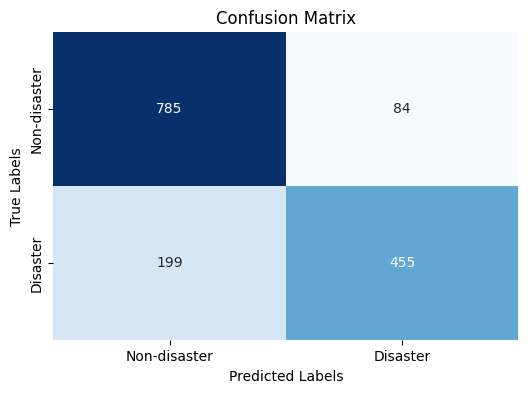

In [155]:
confusion_matrix_heat_map(y_pred_log_regression)